In [38]:
import pandas as pd
import networkx as nx
from karateclub import LabelPropagation, FeatherGraph, Diff2Vec, RandNE
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from node2vec import Node2Vec
from gensim.models import Word2Vec
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report

Should be possible to predict value of address given graph structure

In [30]:
financial_transactions = pd.read_csv("data/financial_transactions.csv", index_col='_id')
non_financial_transactions = pd.read_csv("data/non_financial_transactions.csv",index_col='_id')

In [31]:
transactions = pd.concat([financial_transactions,non_financial_transactions])

In [32]:
transactions.timestamp = pd.to_datetime(transactions.timestamp, unit='s')

In [33]:
graph = nx.from_pandas_edgelist(transactions,'sender','receiver','value',nx.MultiDiGraph(),'timestamp')

In [41]:
graph.degree(["0x91ADf14f4C0782634E04Dfc6e9Be16d950AA4daA",'0x781CBe05baD0B662706dBb796f0c3BDa2f85C60c'], weight='value')

DiMultiDegreeView({})

In [37]:
graph = nx.convert_node_labels_to_integers(graph,label_attribute='address')
node_address_mapping = nx.get_node_attributes(graph, "address")

In [8]:
graph_emb = Node2Vec(graph, dimensions=16)

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:49<00:00, 10.93s/it]


In [9]:
model = graph_emb.fit()

In [10]:
model.save('node2vec.model')

In [ ]:
model = Word2Vec.load("node2vec.model")

In [11]:
edges = list(graph.edges())

In [33]:
non_edges = list(nx.non_edges(graph.subgraph(random.sample(range(0, 413163), 1000))))

In [34]:
non_edge_count = len(edges)
relevant_edges = random.sample(non_edges,non_edge_count)+edges
is_con = list(np.zeros(non_edge_count))+list(np.ones(len(edges)))

In [35]:
X = pd.DataFrame(relevant_edges, columns=['sender','receiver'])
target = 'target'
X[target] = is_con

In [36]:
edge_features = [(model.wv.get_vector(i)+model.wv.get_vector(j)) for i,j in tqdm(relevant_edges)]

100%|██████████| 2065815/2065815 [00:08<00:00, 238651.48it/s]


In [37]:
edge_col_list = ['edge_feature_{}'.format(i) for i in range(16)]
edge_features_df = pd.DataFrame(edge_features,columns=edge_col_list)
X = pd.concat([X, edge_features_df], axis=1)

In [54]:
X.sender = X.sender.map(node_address_mapping)
X.receiver = X.receiver.map(node_address_mapping)

In [58]:
X = X.set_index(['sender','receiver'])
y = X.pop(target)

In [60]:
train_features, test_features, train_labels, test_labels = train_test_split(
    X, y, test_size=0.1, random_state=1
)

In [61]:
n = 1000
xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,
    tree_method = "hist",
    n_estimators=n,
    single_precision_histogram=True,
    objective='binary:logistic',
    eval_metric=["rmse","error","logloss"],
    early_stopping_rounds=1000,
)
eval_set = [(train_features, train_labels),(test_features,test_labels)]
xgb_model = xgb_model.fit(train_features, train_labels, eval_set=eval_set, verbose=100)

[0]	validation_0-rmse:0.47110	validation_0-error:0.11895	validation_0-logloss:0.63690	validation_1-rmse:0.47093	validation_1-error:0.11676	validation_1-logloss:0.63657
[100]	validation_0-rmse:0.29491	validation_0-error:0.10415	validation_0-logloss:0.30407	validation_1-rmse:0.29345	validation_1-error:0.10262	validation_1-logloss:0.30213
[200]	validation_0-rmse:0.28224	validation_0-error:0.09639	validation_0-logloss:0.28080	validation_1-rmse:0.28166	validation_1-error:0.09534	validation_1-logloss:0.28054
[300]	validation_0-rmse:0.27520	validation_0-error:0.09161	validation_0-logloss:0.26810	validation_1-rmse:0.27551	validation_1-error:0.09118	validation_1-logloss:0.26944
[400]	validation_0-rmse:0.26930	validation_0-error:0.08807	validation_0-logloss:0.25761	validation_1-rmse:0.27042	validation_1-error:0.08831	validation_1-logloss:0.26037
[500]	validation_0-rmse:0.26460	validation_0-error:0.08550	validation_0-logloss:0.24934	validation_1-rmse:0.26651	validation_1-error:0.08608	validation_

In [62]:
xgb_model.save_model('link_classifier.json')

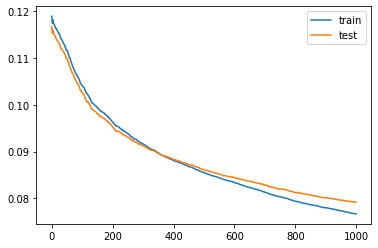

In [63]:
results = xgb_model.evals_result()
plt.plot(results['validation_0']['error'],label='train')
plt.plot(results['validation_1']['error'],label='test')
plt.legend()
plt.show()

In [64]:
predictions_series = pd.Series(xgb_model.predict(test_features),index=test_labels.index)

In [65]:
print("Testing Accuracy : ", accuracy_score(test_labels, predictions_series.round()))
print("MCC Score : ", matthews_corrcoef(test_labels, predictions_series.round()))
print("Test Classification Report : ")
print(classification_report(test_labels, predictions_series.round()))

Testing Accuracy :  0.9208691947991596
MCC Score :  0.7382969255687408
Test Classification Report : 
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    165548
         1.0       0.98      0.62      0.76     41034

    accuracy                           0.92    206582
   macro avg       0.95      0.81      0.85    206582
weighted avg       0.93      0.92      0.91    206582



<AxesSubplot:title={'center':'Feature importance'}, xlabel='weight', ylabel='Features'>

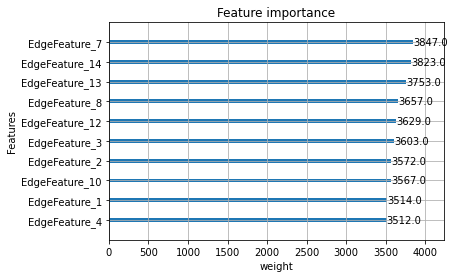

In [66]:
xgb.plot_importance(xgb_model,max_num_features=10,importance_type='weight',xlabel='weight')

In [74]:
def predict_link(entity_1: str, entity_2: str, n2v_model, xgb_model):

    entity_1 = list(node_address_mapping.keys())[list(node_address_mapping.values()).index(entity_1)]
    entity_2 = list(node_address_mapping.keys())[list(node_address_mapping.values()).index(entity_2)]
    edge_col_list = ['EdgeFeature_{}'.format(i) for i in range(16)]
    # entity_1_col_list = ['Entity_1_Feature_{}'.format(i) for i in range(16)]
    # entity_2_col_list = ['Entity_2_Feature_{}'.format(i) for i in range(16)]

    prediction_df = pd.DataFrame({'Entity_1':entity_1, 'Entity_2':entity_2}, index=[0])
    edge_feature = (n2v_model.wv.get_vector(entity_1)+n2v_model.wv.get_vector(entity_2))

    edge_feature_df = pd.DataFrame([edge_feature],columns=edge_col_list)
    prediction_df = pd.concat([prediction_df, edge_feature_df], axis=1)
    
    # prediction_entity_1_emb_df = (
    # pd.DataFrame([n2v_model.wv.get_vector(entity_1)],
    #     columns= entity_1_col_list
    # )
    # )
    # prediction_entity_1_emb_df['Entity_1'] = entity_1

    # prediction_entity_2_emb_df = (
    # pd.DataFrame(
    #     [n2v_model.wv.get_vector(entity_2)],
    #     columns= entity_2_col_list
    # )
    # )
    # prediction_entity_2_emb_df['Entity_2'] = entity_2

    # prediction_df = pd.merge(prediction_df,prediction_entity_1_emb_df,on='Entity_1')
    # prediction_df = pd.merge(prediction_df,prediction_entity_2_emb_df,on='Entity_2')
    prediction_df = prediction_df.set_index(['Entity_1','Entity_2'])
    prediction = xgb_model.predict_proba(prediction_df)
    return prediction

In [85]:
predict_link('0x8B77f112d0F6dC57DFaB82C6Af2858A3771aA82B','0xDB044B8298E04D442FdBE5ce01B8cc8F77130e33',model,xgb_model)

array([[6.258488e-05, 9.999374e-01]], dtype=float32)

Cant really see the value in predicting which addresses a user would want to interact with without having any notion of a market place or the products and services that are exchanges

We can use node embeddings to predict other behaviour but this requires outside data about individual addresses. Can we use it trade crypto?